In [3]:
import pandas as pd
import geopandas as gpd
import json 
from shapely.geometry import shape, Point
import shapely

import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import folium

from vincenty import vincenty

import requests
import urllib.parse
import re

from sklearn import preprocessing


# Option d'affchage
pd.set_option('display.max_columns', None)

In [4]:
# Si la base de données n'est pas déjà téléchargée
# df0 = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2', sep = '|')

# Sinon
df0 = pd.read_csv('data/valeursfoncieres-2019.txt', sep = '|')


In [5]:
df0.shape

(2535791, 43)

# I. Nettoyage de la base de données

In [6]:
df1 = df0.copy()

df1.sample(5)

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
1336669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,05/11/2019,Vente,"48300,00",NaN,NaN,NaN,C024,LE PRE COURT,53220.0,LARCHAMP,53,126,NaN,D,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,P,NaN,30840.0
509487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,17/01/2019,Vente,"320000,00",4.0,NaN,RTE,0056,DU VAL AU GRAIN,27220.0,LA BOISSIERE,27,78,NaN,B,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,33.0,2.0,S,NaN,654.0
1246869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,03/12/2019,Vente,"150,00",NaN,NaN,NaN,B106,LA FONTAINE,49650.0,ALLONNES,49,2,NaN,B,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,21650.0
332434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,14/01/2019,Vente,"92700,00",5000.0,NaN,IMP,0280,DE L EGLISE,17120.0,MORTAGNE-SUR-GIRONDE,17,248,NaN,AB,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,60.0,3.0,S,NaN,45.0
141780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,25/07/2019,Vente,"2876,00",NaN,NaN,NaN,B001,AUZIS,7610.0,VION,7,345,NaN,A,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,L,NaN,1438.0


## 1. Séléction des variables intéressantes

In [7]:
df1.columns

Index(['Code service CH', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='object')

In [8]:
df = df1[[
        'Date mutation', 'Nature mutation', 'Valeur fonciere',
        'No voie', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
        'Commune', 'Code departement', 'Code commune', 'Type local',
        'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
        'Section', 'No plan'
        ]]

df.sample(5)

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Section,No plan
1648713,16/10/2019,Vente,"103000,00",123.0,RUE,1630,PIERRE BRUNIER,69300.0,CALUIRE ET CUIRE,69,34,Dépendance,0.0,0.0,NaN,BL,283
953211,10/09/2019,Vente,"305784,00",NaN,NaN,B031,GRAND TOURREN,40230.0,ST-VINCENT-DE-TYROSSE,40,284,NaN,NaN,NaN,NaN,AE,77
1989843,17/04/2019,Vente,"235000,00",19.0,RUE,0660,DES PILOTES,80230.0,SAINT-VALERY-SUR-SOMME,80,721,Maison,36.0,3.0,31.0,AH,46
635026,31/01/2019,Vente,"5996088,00",1.0,IMP,0294,ANDRE CAMPRA,31100.0,TOULOUSE,31,555,Appartement,30.0,2.0,NaN,BM,10
1759332,21/10/2019,Vente,"379370,00",15.0,RUE,3478,AIME MUGNIER,74600.0,ANNECY,74,10,Dépendance,0.0,0.0,NaN,D,2489


### Premier tri pour garder les biens qui nous intéressent dans le cadre que l'on s'est donné

In [9]:
df = df[df['Nature mutation'] == 'Vente']
df = df[df['Code departement'] == 75]
df = df[df['Type local'] == 'Appartement']
df = df[pd.isna(df['Surface terrain'])] # Vu qu'on va essayer de prédir un prix au m2, la surface est une donnée indispensable

### Changement du nom des variables

In [10]:
df = df[[
        'Date mutation', 'Valeur fonciere', 'No voie', 
        'Type de voie', 'Voie', 'Code postal', 'Surface reelle bati', 
        'Nombre pieces principales',
        'Code departement', 'Code commune', 'Code voie',
        'Type local', 'Section', 'No plan'
        ]]

df = df.rename(columns = {
                            'Date mutation': 'Date', 
                            'Valeur fonciere': 'Valeur',
                            'Type de voie': 'TypeVoie',
                            'No voie': 'Numero',
                            'Code postal': 'CodePostal',
                            'Surface reelle bati': 'Surface',
                            'Nombre pieces principales': 'NbPieces',
                            'Surface terrain': 'SurfaceTerrain',
                            'Code departement': 'Code_departement', 
                            'Code commune': 'Code_commune', 
                            'Code voie': 'Code_voie',
                            'Type local': 'TypeLocal',
                            'No plan': 'No_plan'
                         }
              )

## 2. Gestion des variables

In [11]:
df.dtypes

Date                 object
Valeur               object
Numero              float64
TypeVoie             object
Voie                 object
CodePostal          float64
Surface             float64
NbPieces            float64
Code_departement     object
Code_commune          int64
Code_voie            object
TypeLocal            object
Section              object
No_plan               int64
dtype: object

On remarque que la variable "Valeur" n'est pas de type float ou int, il va falloir y remédier !

### Valeur

In [12]:
# Les biens dont la valeur n'est pas renseignée ne nous intéressent pas
df = df.dropna(subset = ['Valeur'])

# Changement des virgules en point pour pouvoir convertir les types str en types float
df['Valeur'] = df.apply(lambda row : str(row.Valeur).replace(',', '.'), axis = 1)
df['Valeur'] = pd.to_numeric(df['Valeur'])

# On divise par 1000 les prix pour plus de lisibilité
df['Valeur'] = df['Valeur']/1000

# On se concentre sur une tranche de prix "raisonnable"
df = df[df['Valeur'] > 60]
df = df[df['Valeur'] < 15000]

# Pour déterminer ces bornes, nous sommes allé sur des sites d'immobiliers à Paris pour trouver les valeurs extrêmes

### Surface

Un logement mis en location doit respecter une surface minimum. Il s'agit d'un des critères de décence du logement.

Le logement doit comporter au moins une pièce principale présentant :

une surface habitable de 9 m² et une hauteur sous plafond minimale de 2,20 mètres,
ou un volume habitable de 20 m³.

In [13]:
df = df[df['Surface'] >= 9]

### Création de la variable du prix par metre carré (prixm2)

In [14]:
df['prixm2'] = df['Valeur'] / df['Surface']

### Date

In [15]:
display(df.sort_values('Date')[['Date']].head())
df[pd.isna(df['Date'])].shape

# Il ne semble pas y avoir de valeurs manquantes

,Date
2519832,01/02/2019
2478301,01/02/2019
2482940,01/02/2019
2482948,01/02/2019
2482963,01/02/2019


(0, 15)

### Elements d'adresse (Numero, TypeVoie,  Voie, CodePostal)

In [16]:
# Numero
print(df[pd.isna(df['Numero'])].shape)

# Tous les appartments ont un numéro indiqué. On est satisfait car on souhaite une localisation précise des appartements

(0, 15)


In [17]:
# TypeVoie

print(df[pd.isna(df['TypeVoie'])].shape)

# 15 valeurs manquantes, on regarde à quoi elles correspondent

display(df[pd.isna(df['TypeVoie'])])

# Cela correspond à des adresses où le type de voie est spécial (Villa, Pont, Autoroute, Rond point) 
# et est contenu dans la variable Voie
# On laisse comme ca

(15, 15)


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,Code_departement,Code_commune,Code_voie,TypeLocal,Section,No_plan,prixm2
2478666,28/02/2019,429.70,30.0,NaN,VIL WAGRAM SAINT HONORE,75008.0,41.0,1.0,75,108,9936,Appartement,AX,19,10.480488
2495603,03/06/2019,896.60,3.0,NaN,N 11,75011.0,100.0,3.0,75,111,X421,Appartement,CT,37,8.966000
2500112,03/07/2019,217.00,4.0,NaN,ALLEE DES HORTENSIAS,75014.0,18.0,1.0,75,114,R072,Appartement,CW,47,12.055556
2501436,14/02/2019,339.70,3.0,NaN,VLA HONORE GABRIEL RIQUETI,75015.0,31.0,1.0,75,115,4648,Appartement,FX,5,10.958065
2501524,13/02/2019,250.00,6.0,NaN,VIL DU MONT TONNERRE,75015.0,25.0,1.0,75,115,6539,Appartement,CR,26,10.000000
2501686,13/02/2019,970.00,7.0,NaN,DU PONT MIRABEAU,75015.0,120.0,4.0,75,115,7616,Appartement,FW,19,8.083333
2502474,15/04/2019,309.06,3.0,NaN,VIL DU MONT TONNERRE,75015.0,21.0,2.0,75,115,6539,Appartement,CR,43,14.717143
2503541,10/05/2019,856.00,9003.0,NaN,METRO BOUCICAUT,75015.0,78.0,4.0,75,115,S049,Appartement,EN,26,10.974359
2504640,12/07/2019,860.00,7.0,NaN,VLA HONORE GABRIEL RIQUETI,75015.0,80.0,3.0,75,115,4648,Appartement,FX,5,10.750000
2504703,16/07/2019,570.00,158.0,NaN,R-PTSAINT CHARLES,75015.0,70.0,2.0,75,115,8512,Appartement,ER,32,8.142857


In [18]:
# Voie
display(df.sort_values('Voie')[['Voie']].head())
print(df[pd.isna(df['Voie'])].shape)

# Il ne semble pas y avoir de valeurs manquantes

,Voie
2493978,A 11
2528149,AB 20
2532159,AB 20
2494739,ABEL
2497687,ABEL HOVELACQUE


(0, 15)


In [19]:
# CodePostal

print(df[pd.isna(df['CodePostal'])].shape)

# 1 valeur manquante, on regarde à quoi elle correspond

display(df[pd.isna(df['CodePostal'])])

# La rue de l'Abbé Groult se situe dans le 15ème, on remplit à la main

df.at[2503844, 'CodePostal'] = float(75015)

display(df.loc[[2503844]])

(1, 15)


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,Code_departement,Code_commune,Code_voie,TypeLocal,Section,No_plan,prixm2
2503844,23/05/2019,150.0,23.0,RUE,DE L ABBE GROULT,NaN,19.0,1.0,75,115,0012,Appartement,BQ,16,7.894737


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,Code_departement,Code_commune,Code_voie,TypeLocal,Section,No_plan,prixm2
2503844,23/05/2019,150.0,23.0,RUE,DE L ABBE GROULT,75015.0,19.0,1.0,75,115,0012,Appartement,BQ,16,7.894737


### NbPieces (nombre de pièces)

In [20]:
print(df[pd.isna(df['NbPieces'])].shape)

display(df.sort_values('NbPieces')[['NbPieces']].head())

# Pas de valeurs manquantes mais des appartements à 0 pièces...

display(df[df['NbPieces'] == 0].head())

# Les entrées n'ont pas l'air des anomalies, la valeur doit être manquante, on laisse tel quel en gardant à l'esprit cette observation

(0, 15)


,NbPieces
2483400,0.0
2490090,0.0
2515185,0.0
2499758,0.0
2509412,0.0


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,Code_departement,Code_commune,Code_voie,TypeLocal,Section,No_plan,prixm2
2479736,17/06/2019,346.75,10.0,RUE,SAINTE ANASTASE,75003.0,29.0,0.0,75,103,8531,Appartement,AL,106,11.956897
2480202,12/07/2019,120.00,17.0,BD,SAINT MARTIN,75003.0,18.0,0.0,75,103,8692,Appartement,AF,8,6.666667
2480249,02/07/2019,342.50,22.0,RUE,DE PICARDIE,75003.0,12.0,0.0,75,103,7395,Appartement,AH,10,28.541667
2482477,17/12/2019,774.60,6.0,RUE,SAINT FLORENTIN,75001.0,18.0,0.0,75,101,8611,Appartement,BD,5,43.033333
2483400,12/03/2019,169.85,54.0,RUE,HENRI BARBUSSE,75005.0,31.0,0.0,75,105,4535,Appartement,BF,24,5.479032


#### Création de la variable 'id' qui permettra d'identifier l'adresse précise dans une autre bdd

In [21]:
def code_numero(numero):
    """Créé le code utilisé pour identifier le numero d'une rue au sein du code 'id' 

    Argument :
    numero : float
        numero de la rue tel que présent dans la base de données

    Return :
    code : str
        Le code correspondant (format 00007 pour le numéro 7 d'une rue, par exemple)
    """

    code = str(int(numero))
    code = '0' * (5 - len(code)) + code

    return code

df['id'] = df['Code_departement'].astype(str) + df['Code_commune'].astype(str) + '_' + df['Code_voie'].astype(str) + '_' + df['Numero'].apply(code_numero)

df = df.drop(columns = ['Code_commune', 'Code_departement', 'Code_voie'])

# Vérification

df.head(5)

,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,TypeLocal,Section,No_plan,prixm2,id
2478017,04/01/2019,1196.00,17.0,RUE,DUPHOT,75001.0,112.0,3.0,Appartement,BC,14,10.678571,75101_2999_00017
2478018,03/01/2019,1570.49,13.0,RUE,DE THORIGNY,75003.0,104.0,3.0,Appartement,AL,15,15.100865,75103_9298_00013
2478022,10/01/2019,230.00,4.0,RUE,BLONDEL,75003.0,26.0,1.0,Appartement,AB,130,8.846154,75103_1021_00004
2478024,05/01/2019,955.75,82.0,BD,MALESHERBES,75008.0,80.0,3.0,Appartement,CG,21,11.946875,75108_5951_00082
2478025,07/01/2019,506.80,4.0,CITE,DUPETIT THOUARS,75003.0,45.0,2.0,Appartement,AG,72,11.262222,75103_2996_00004


In [22]:
# Petite sauvegadre de la base à ce stade

dfv0 = df.copy()

In [23]:
df = dfv0.copy()

## 3. Choix de la variable à prédir

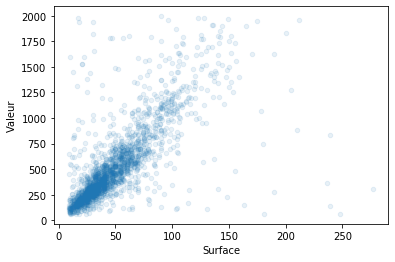

In [24]:
# On peut tracer le prix en fonction de la surface

df[df['Valeur'] < 2000].sample(2000).plot(x = 'Surface', y = 'Valeur', kind = 'scatter', alpha = .1)
# On a tracé le graphe pour les appartements ayant un prix inférieur à 2 millions

On voit une relation linéaire apparaitre, justifiée par un coefficient de corrélation significatif, de 0.58 

In [25]:
df['Valeur'].corr(df['Surface'])

0.5773341774970066

#### On fait donc l'hypothèse qu'il y a une corélation linéaire entre le prix d'un appartement et sa surface en m2.
#### On se donnera donc pour objectif de prédir le prix au m2 d'un appartement en fonction de différents paramètres.

## 4. Gestion des anomalies

La base de données n'est pas parfaite, certaines entrées sont erronées.
La premier nettoyage que nous allons faire, qui est aussi le plus grossier, est de se restreindre à des prix au m2 raisonnables.
#### Le site meilleursagents.com recense les prix au m2 de nombreux appartements à Paris. 
#### Les prix les plus bas observé sont environ de 4 700 €/m2
#### Les prix les plus hauts observés sont environ de 32 000 €/m2

#### On choisit donc de considérer les biens dont le prix au m2 est compris entre 4 230 € et 35 200 (marge de 10%)

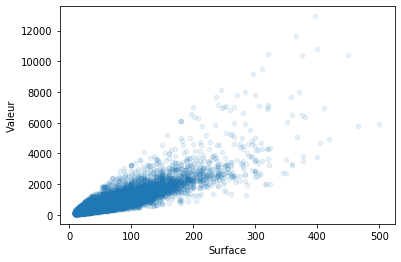

In [26]:
df = df[df['prixm2'] > 4.23]
df = df[df['prixm2'] < 35.2]

df.plot(x = 'Surface', y = 'Valeur', kind = 'scatter', alpha = .1)

In [25]:
df['Valeur'].corr(df['Surface']) # Nouveau coefficient de corrélation : 0.88

0.875405776217457

# Couplage : date de construction du bâtis

Pour obtenir la date de construction des immeubles, on utilise deux nouvelles bases :  
    -df_dates qui donne la date de construction à partir d'un identificateur id2  
    -df_join qui associe l'identificateur id2 à une adresse
    
   df_join va donc nous permettre de faire la jointure entre la base d'origine et la base df_dates pour obtenir la date deconstruction des immeubles.

In [93]:
# Importation des bases
df_dates = pd.read_csv('data/date_construction.csv', sep = ',')
df_join = pd.read_csv('data/PARCELLE_CADASTRALE.csv', sep = ',')

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



In [94]:
# On garde que les variables qui nous intéressent
df_join = df_join[['n_sq_pc', 'c_sec', 'n_pc']]
df_dates = df_dates[['n_sq_pc', 'c_perconst']]

In [95]:
# On regroupe les deux bases grâce à l'identificateur
df_dates = df_dates.merge(df_join, left_on = 'n_sq_pc', right_on = 'n_sq_pc')
df_dates = df_dates.drop(columns = ['n_sq_pc'])

In [96]:
# On crée l'identificateur dans la base d'origine et le fait correspondre avec celui de la base des dates
df['id2'] = df.apply(lambda row: str(row.Section) + str(row.No_plan), axis = 1)
df_dates['id2'] = df_dates.apply(lambda row: str(row.c_sec) + str(row.n_pc), axis = 1)
df_dates = df_dates.drop_duplicates(subset = ['id2'], keep = 'first')

display(df_dates.head(10))
display(df.head(10))


# On joint les deux bases
df = pd.merge(df, df_dates, on = 'id2')



,c_perconst,c_sec,n_pc,id2
0,5.0,FX,57,FX57
1,3.0,EF,1,EF1
3,3.0,BT,61,BT61
6,3.0,AM,45,AM45
7,6.0,DV,2,DV2
12,3.0,AQ,7,AQ7
13,3.0,EL,24,EL24
15,3.0,AB,2,AB2
16,3.0,AR,14,AR14
19,5.0,EG,7,EG7


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,TypeLocal,Section,No_plan,prixm2,id,id2
2478017,04/01/2019,1196.00,17.0,RUE,DUPHOT,75001.0,112.0,3.0,Appartement,BC,14,10.678571,75101_2999_00017,BC14
2478018,03/01/2019,1570.49,13.0,RUE,DE THORIGNY,75003.0,104.0,3.0,Appartement,AL,15,15.100865,75103_9298_00013,AL15
2478022,10/01/2019,230.00,4.0,RUE,BLONDEL,75003.0,26.0,1.0,Appartement,AB,130,8.846154,75103_1021_00004,AB130
2478024,05/01/2019,955.75,82.0,BD,MALESHERBES,75008.0,80.0,3.0,Appartement,CG,21,11.946875,75108_5951_00082,CG21
2478025,07/01/2019,506.80,4.0,CITE,DUPETIT THOUARS,75003.0,45.0,2.0,Appartement,AG,72,11.262222,75103_2996_00004,AG72
2478026,07/01/2019,565.95,79.0,RUE,DU ROCHER,75008.0,55.0,3.0,Appartement,CG,60,10.290000,75108_8291_00079,CG60
2478028,09/01/2019,582.00,13.0,RUE,DU PONT AUX CHOUX,75003.0,41.0,2.0,Appartement,AL,51,14.195122,75103_7605_00013,AL51
2478029,09/01/2019,200.00,39.0,RUE,D ARTOIS,75008.0,28.0,1.0,Appartement,BF,30,7.142857,75108_0487_00039,BF30
2478030,08/01/2019,2638.50,67.0,BD,DE COURCELLES,75008.0,260.0,8.0,Appartement,AY,32,10.148077,75108_2386_00067,AY32
2478031,07/01/2019,1935.60,24.0,RUE,DE MONTPENSIER,75001.0,66.0,2.0,Appartement,AV,33,29.327273,75101_6528_00024,AV33


In [97]:
# Et on néttoie le tout
df = df.drop(columns = ['id2', 'c_sec', 'n_pc', 'Section', 'No_plan'])
df = df.rename(columns = {'c_perconst': 'periode_construction'})

In [98]:
px.histogram(df, x = 'periode_construction')

In [99]:
# La catégorie 4 n'existe pas, on recode pour que ca soit plus compréhensif
def ajustement(valeur):
    if valeur in [i for i in range(5, 13)]:
        return valeur - 1
    elif valeur == 99:
        return 0
    else:
        return valeur

df['periode_construction'] = df.apply(lambda row: ajustement(row.periode_construction), axis = 1)


In [100]:
px.histogram(df, x = 'periode_construction')

In [101]:
df.shape

(29707, 12)

On obtient ici plusieurs tranches de périodes de constructions :  
0   Données manquantes  
1	Avant 1800	
2	1801-1850	
3	1851-1914	
4	1915-1939	
5	1940-1967	
6	1968-1975	
7	1976-1981	
8	1982-1989	
9	1990-1999	
10	2000-2007	
11	2008 et plus

### Ajout de la variable arrondissement

In [27]:
df['Arrondissement'] = df.apply(lambda row: int(str(int(row.CodePostal))[3:5]), axis = 1)

# Couplage avec la base des données GPS

On souhaite obtenir les coordonnées GPS de tous les appartements présents dans la base.
Pour cela, nous avons trouvé une base de données qui répertorient toutes les adresses parisiennes et leur associe des coordonnées GPS.
Pour coupler les deux bases, nous utiliserons la variable id.
Ce code id est de la forme WWXXX_YYYY_ZZZZZ avec : 	
##### WW est le code département (75 ici)
##### XXX est le code commune (115 pour le 15ème arrondissement)
##### YYYY est le code voie (4903 pour l'avenue Jean Jaurès par exemple)
##### ZZZZ est le numéro (00005 pour le 5)


In [28]:
df2 = pd.read_csv('https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-75.csv.gz', sep = ';').copy()

In [29]:
df2[df2['id'].str[:2] == '75'].sample(5)

,id,id_fantoir,numero,rep,nom_voie,code_postal,code_insee,nom_commune,code_insee_ancienne_commune,nom_ancienne_commune,x,y,lon,lat,alias,nom_ld,libelle_acheminement,nom_afnor,source_position,source_nom_voie
104997,75110_7067_00160,75110_7067,160,NaN,Avenue Parmentier,75010,75110,Paris 10e Arrondissement,NaN,NaN,653837.14,6863596.36,2.370676,48.870738,NaN,NaN,PARIS,AVENUE PARMENTIER,commune,commune
15363,75119_4481_00001,75119_4481,1,NaN,Rue Hassard,75019,75119,Paris 19e Arrondissement,NaN,NaN,654821.74,6864426.13,2.384010,48.878270,NaN,NaN,PARIS,RUE HASSARD,commune,commune
19452,75119_4137_00039,75119_4137,39,NaN,Rue Georges Lardennois,75019,75119,Paris 19e Arrondissement,NaN,NaN,654222.02,6864349.83,2.375841,48.877542,NaN,NaN,PARIS,RUE GEORGES LARDENNOIS,commune,commune
140842,75105_7102_00001,75105_7102,1,NaN,Passage des Patriarches,75005,75105,Paris 5e Arrondissement,NaN,NaN,652336.24,6860316.35,2.350583,48.841132,NaN,NaN,PARIS,PASSAGE DES PATRIARCHES,commune,commune
4721,75101_2318_00043,75101_2318,43,NaN,Rue Coquillière,75001,75101,Paris 1er Arrondissement,NaN,NaN,651628.09,6862930.56,2.340637,48.864589,NaN,NaN,PARIS,RUE COQUILLIERE,commune,commune


### Séléction des variables intéressantes

In [30]:
df_GPS = df2[[
        'id', 'lon', 'lat', 
        ]]

# x et y : Coordonnées cartographique en projection légale
# lon et lat : Coordonnées en WGS-84	

df_GPS.sample(10)

,id,lon,lat
132367,75106_4367_00031,2.338021,48.855342
45623,75118_7755_00075,2.339067,48.896087
8409,75102_8686_00025,2.339737,48.870453
44947,75120_4576_00002,2.389490,48.872668
117184,75111_8500_00031,2.380884,48.852703
34460,75120_0610_00105,2.406856,48.852926
51870,75118_4355_00005_bis,2.362264,48.890642
86244,75113_7721_00040,2.371095,48.820859
99094,75115_6167_00001_s,2.313141,48.841161
80413,75113_4754_00011,2.356476,48.829648


### Couplage avec df

In [31]:
print(df.shape)
df = df.merge(df_GPS, left_on = 'id', right_on = 'id')
print(df.shape)
# On perd a peine 1000 valeurs
display(df.sample(10))

(29761, 14)
(29676, 16)


,Date,Valeur,Numero,TypeVoie,Voie,CodePostal,Surface,NbPieces,TypeLocal,Section,No_plan,prixm2,id,Arrondissement,lon,lat
12743,04/10/2019,294.00,18.0,RUE,MIOLLIS,75015.0,33.0,2.0,Appartement,CY,57,8.909091,75115_6377_00018,15,2.304616,48.846096
11967,08/02/2019,921.49,54.0,RUE,LABROUSTE,75015.0,107.0,5.0,Appartement,AI,101,8.612056,75115_5209_00054,15,2.307410,48.833296
16824,31/05/2019,500.00,91.0,RUE,MICHEL ANGE,75016.0,51.0,2.0,Appartement,AS,27,9.803922,75116_6324_00091,16,2.258473,48.840620
20977,16/01/2019,605.85,21.0,RUE,ACHILLE MARTINET,75018.0,59.0,2.0,Appartement,AW,90,10.268644,75118_0051_00021,18,2.337172,48.892585
25174,01/02/2019,135.00,2.0,CITE,ADRIENNE,75020.0,21.0,1.0,Appartement,CX,52,6.428571,75120_0077_00002,20,2.401406,48.858492
20280,27/09/2019,569.40,9.0,RUE,TRUFFAUT,75017.0,52.0,2.0,Appartement,CO,16,10.950000,75117_9487_00009,17,2.322941,48.884646
16057,07/05/2019,976.00,16.0,RUE,DE SIAM,75016.0,90.0,4.0,Appartement,DI,34,10.844444,75116_8964_00016,16,2.274455,48.862499
5923,11/12/2019,306.50,9.0,BD,DE ROCHECHOUART,75009.0,30.0,2.0,Appartement,BC,59,10.216667,75109_8288_00009,9,2.348360,48.883391
16053,25/04/2019,2005.00,15.0,RUE,DURET,75016.0,145.0,5.0,Appartement,FA,31,13.827586,75116_3039_00015,16,2.285640,48.874247
8584,02/05/2019,145.00,6.0,RUE,DE MADAGASCAR,75012.0,20.0,1.0,Appartement,BR,69,7.250000,75112_5884_00006,12,2.397316,48.834845


On peut donc maintenant représenter les appartements dans un plan de Paris.

On constate bien les faits stylisé déjà connu : 
#### Les quartiers périphériques sont en général moins chers que les quartiers centraux.
#### Les quartiers de l'ouest sont plus chers que ceux à l'est.

# II. Traitement des données - ajout de variables


In [32]:
df_ml = df.drop(columns = ['Date', 'Valeur', 'Surface',
                           'Voie', 'CodePostal', 'TypeLocal', 'id'])
df_ml.sample(10)

,Numero,TypeVoie,NbPieces,Section,No_plan,prixm2,Arrondissement,lon,lat
11327,6.0,RUE,2.0,BP,24,8.333333,14,2.337621,48.831598
22018,35.0,RUE,1.0,CG,77,23.733333,18,2.356161,48.887680
21251,25.0,RUE,4.0,CF,149,9.181000,18,2.353460,48.888106
7667,282.0,RUE,1.0,DE,14,9.333333,12,2.391867,48.836320
16976,98.0,RUE,1.0,AR,77,10.707692,16,2.261658,48.839870
24840,123.0,AV,2.0,ET,9,9.920000,19,2.373835,48.880651
25738,183.0,RUE,4.0,CN,4,9.571429,20,2.400333,48.860892
20622,174.0,BD,1.0,BV,51,8.000000,17,2.304759,48.887938
21812,5.0,RUE,1.0,CK,17,7.500000,18,2.358150,48.889237
7890,135.0,RUE,1.0,HA,36,8.888889,12,2.381294,48.845302


In [33]:
corr_matrix = df_ml.corr()
corr_matrix["prixm2"].sort_values(ascending = False)
# les variables sont toutes plutôt décorélées avec le prix au m2

prixm2            1.000000
NbPieces          0.052549
No_plan           0.004837
Numero           -0.058504
lat              -0.060936
lon              -0.158746
Arrondissement   -0.282588
Name: prixm2, dtype: float64

Pour les variables suivantes, on considère une petite proportion de la base totale (pour l'exemple, calculs trop longs)

In [37]:
#df_ml.sample(10)

,Numero,TypeVoie,NbPieces,Section,No_plan,prixm2,lon,lat
14670,10.0,RUE,1.0,DL,58,12.534615,2.294318,48.852981
15725,15.0,RUE,1.0,FP,33,14.761905,2.297908,48.867168
15863,35.0,RUE,3.0,FR,34,14.555636,2.289451,48.864945
27399,84.0,RUE,1.0,DO,112,5.357143,2.403795,48.854955
7097,1.0,RUE,1.0,AD,82,7.222222,2.376418,48.870375
12557,161.0,BD,3.0,AO,18,7.245614,2.300527,48.829098
735,21.0,RUE,1.0,AQ,75,12.305556,2.362746,48.861532
28810,20.0,RUE,2.0,AJ,18,12.561667,2.354789,48.857356
22074,1.0,RUE,3.0,CK,34,8.796296,2.359469,48.890158
7738,4.0,RUE,2.0,AR,102,15.866000,2.373956,48.864486


## Quartier administatif

In [110]:
df_quartier = pd.read_csv('data/quartier_paris.csv', sep = ';')

In [111]:
df_quartier = df_quartier[['c_qu', 'geom']]
df_quartier['geom'] = df_quartier.apply(lambda row: json.loads(row.geom), axis = 1)
geom = [shape(i) for i in df_quartier['geom']]
df_quartier['geom'] = gpd.GeoDataFrame({'geometry':geom})['geometry']

In [112]:
def determine_quartier(lat, lon):
    
    for _, row in df_quartier.iterrows():
        
        polygon = row.geom
        
        if polygon.contains(Point(lon, lat)):
            return row.c_qu
        
    return 0

In [113]:
df_ml['Quartier'] = df_ml.apply(lambda row: determine_quartier(row.lat, row.lon), axis = 1)

## Proximité aux jardins 



In [114]:
df_jardin = pd.read_csv('data/espaces_verts.csv', sep = ';')

In [115]:
#On ne garde que les espaces verts importants
df_jardin = df_jardin[df_jardin['Catégorie'].isin(['Square', 'Jardin', 'Pelouse', 'Parc', 'Bois'])]

In [116]:
df_jardin = df_jardin[['Superficie totale réelle', 'Geo Shape', '''Nom de l'espace vert''']].rename(columns = {
                                                                    'Superficie totale réelle' : 'Aire',
                                                                    'Geo Shape' : 'geom',
    '''Nom de l'espace vert''' : 'Nom'
                                                                                    }
                                                                       )
df_jardin = df_jardin.reset_index()

In [117]:
df_jardin['geom'] = df_jardin.apply(lambda row: json.loads(str(row.geom)), axis = 1)
geom = [shape(i) for i in df_jardin['geom']]
df_jardin['geom'] = gpd.GeoDataFrame({'geometry':geom})['geometry']

In [118]:
df_jardin = df_jardin.dropna(subset=['Aire'])

In [119]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize = False)
df_jardin[['Aire']] = pt.fit_transform(df_jardin[['Aire']])

min_max_scaler = preprocessing.MinMaxScaler()
df_jardin[['Aire']] = min_max_scaler.fit_transform(df_jardin[['Aire']])

In [120]:
def calcule_score_jardin(lat, lon):
    
    L = []
    for _, row in df_jardin.iterrows():

        polygon = row.geom

        distance = polygon.distance(Point(lon, lat))
        L.append((distance, row.Aire))
        
    L = sorted(L, key=lambda x:  x[0])
    (distance, aire) = L[0]
    score = np.sqrt(aire)/ (distance * 111)
    
    return score

In [121]:
df_ml['score_jardin'] = df_ml.apply(lambda row: calcule_score_jardin(row.lat, row.lon), axis = 1)

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

divide by zero encountered in double_scalars



In [122]:
df_ml.to_csv('data/sauvegarde_0.csv')
df_ml.sample(5)

,Numero,TypeVoie,NbPieces,prixm2,periode_construction,Arrondissement,lon,lat,Quartier,score_jardin
17465,10.0,RUE,6.0,15.214444,3.0,16,2.284638,48.863754,63,3.039299
26793,23.0,RUE,1.0,9.889333,1.0,18,2.327297,48.891044,69,3.818572
13491,3.0,RUE,3.0,9.222222,1.0,20,2.395960,48.867730,79,3.007582
12077,23.0,RUE,2.0,10.312500,3.0,10,2.366837,48.880085,40,3.519819
23131,68.0,RUE,2.0,10.185185,4.0,17,2.326490,48.892705,68,7.488338


## Proximité aux monuments 


In [123]:
df_monuments = pd.read_csv('/Users/lilianmarey/Desktop/Python/PrixImmobilier/data/monuments.csv', sep = ';')

# On standardise le nombre de visiteurs
df_monuments['visiteurs']/=max(df_monuments['visiteurs'])


In [124]:
df_monuments.head()

,nom,visiteurs,lat,lon
0,Musée du Louvre,0.750000,48.860546,2.337612
1,Centre Pompidou,0.261143,48.860637,2.352224
2,Musée d'Orsay,0.241634,48.859959,2.326570
3,Cité des Sciences et de l'Industrie,0.162735,48.895373,2.387874
4,Musée National d'Histoire Naturelle,0.149731,48.843347,2.363467


### Calcul du score de proximité aux monuments

In [125]:
def calcule_scores_monument(lat,lon):

    distances_aux_monuments = []

    for i,row in df_monuments.iterrows():
        distances_aux_monuments.append((row.nom, row.visiteurs, vincenty((row.lat, row.lon), (lat, lon))))

    try:
        score_1 = max([monument[1] for monument in distances_aux_monuments if monument[2] < 1])
    except:
        score_1 = 0

    try:
        score_2 = len([monument[1]/monument[2] for monument in distances_aux_monuments if monument[2] < 3])
    except:
        score_2 = 0

    return (score_1, score_2)

In [126]:
L1, L2 = [], []
print(df_ml.shape)
for _, row in df_ml.iterrows():
    (a,b) = calcule_scores_monument(row.lat, row.lon)
    L1.append(a)
    L2.append(b)

(29622, 10)


In [127]:
df_ml['score_1'], df_ml['score_2'] = L1, L2

df_ml['score_2'] /= max(df_ml['score_2'])

df_ml['score_monument'] = ( (1/5) * df_ml['score_1'] + (4/5) * df_ml['score_2'] ) 

df_ml = df_ml.drop(columns = ['score_1', 'score_2'])
df_ml.head()

,Numero,TypeVoie,NbPieces,prixm2,periode_construction,Arrondissement,lon,lat,Quartier,score_jardin,score_monument
0,17.0,RUE,3.0,10.678571,4.0,1,2.325456,48.868446,4,1.335419,0.848327
1,33.0,RUE,4.0,13.244681,4.0,5,2.342362,48.843993,19,1.453848,0.512641
2,36.0,RUE,1.0,10.852174,4.0,10,2.361984,48.873214,39,6.500860,0.300000
3,36.0,RUE,3.0,8.846154,4.0,10,2.361984,48.873214,39,6.500860,0.300000
4,13.0,RUE,4.0,13.750000,4.0,9,2.345983,48.882664,36,4.932084,0.454412


In [128]:
df_ml.to_csv('data/sauvegarde_0.csv')

## Proximité aux stations de métro

On va ajouter une première variable : le rang des k (k=3 surement) stations de métro les plus proches d'un appartement.

On a besoin :

-d'une fonction qui calcule les distance entre chaque appartement et chaque station de métro. 

--> complexité(nb d'appart) =  nb de stations * nb d'appartement

-d'une fonction qui pour un appartement fixé, trouve les k distances les plus courtes 

--> complexité = k * nb de métro 

-de relier les stations avec leur rang

### Traitement de la base des stations parisiennes

In [129]:
#Importation de la base

df_metro = pd.read_csv( 'data/stations_metro.csv', sep = ';')

df_metro.sample(3)

,Geo Point,Geo Shape,OBJECTID,id_ref_zdl,gares_id,nom_gare,nomlong,nom_iv,num_mod,mode_,fer,train,rer,metro,tramway,navette,val,terfer,tertrain,terrer,termetro,tertram,ternavette,terval,idrefliga,idrefligc,ligne,cod_ligf,ligne_code,indice_lig,reseau,res_com,cod_resf,res_stif,exploitant,num_psr,idf,principal,x,y,picto ligne
549,"48.9027680256,2.23954203632","{""type"": ""Point"", ""coordinates"": [2.2395420363...",485,43729,1087,Les Fauvelles,LES FAUVELLES,Les Fauvelles,0,Tramway,0,0,0,0,1,0,0,0,0,0,0,0,0,0,A01192,NaN,T2,32.0,T2-1506,2,TRAMWAY,T2,5.0,112.0,RATP,0,1,0,644252.6562,6.867242e+06,https://data.iledefrance-mobilites.fr/api/v2/c...
883,"48.9973920018,1.63016762727","{""type"": ""Point"", ""coordinates"": [1.6301676272...",982,46983,749,ROSNY-SUR-SEINE,ROSNY-SUR-SEINE,ROSNY-SUR-SEINE,2688,Train,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,GRD LIGNES,37.0,GRD LIGNES-111,GL,GRANDES LIGNES,GL,6.0,854.0,SNCF,415885,1,0,599766.9049,6.878366e+06,NaN
47,"48.8692241717,2.3546037907","{""type"": ""Point"", ""coordinates"": [2.3546037906...",294,44909,837,Strasbourg-Saint-Denis,STRASBOURG-SAINT-DENIS,Strasbourg-Saint-Denis,2210,Metro,0,0,0,1,0,0,0,0,0,0,0,0,0,0,A01541,NaN,8,15.0,8-109067,8,METRO,M8,3.0,110.0,RATP,0,1,0,652656.8653,6.863438e+06,https://data.iledefrance-mobilites.fr/api/v2/c...


In [130]:
df_metro.columns

Index(['Geo Point', 'Geo Shape', 'OBJECTID', 'id_ref_zdl', 'gares_id',
       'nom_gare', 'nomlong', 'nom_iv', 'num_mod', 'mode_', 'fer', 'train',
       'rer', 'metro', 'tramway', 'navette', 'val', 'terfer', 'tertrain',
       'terrer', 'termetro', 'tertram', 'ternavette', 'terval', 'idrefliga',
       'idrefligc', 'ligne', 'cod_ligf', 'ligne_code', 'indice_lig', 'reseau',
       'res_com', 'cod_resf', 'res_stif', 'exploitant', 'num_psr', 'idf',
       'principal', 'x', 'y', 'picto ligne'],
      dtype='object')

In [131]:
#On garde les colonnes et les lignes qui nous intéressent

df_metro = df_metro[[
        'Geo Point', 'nomlong', 'reseau',
                    ]]

df_metro = df_metro.where(df_metro['reseau'] == 'METRO').dropna()
df_metro.sample(5)

,Geo Point,nomlong,reseau
505,"48.8511923493,2.32648847397",SEVRES-BABYLONE,METRO
263,"48.8825193856,2.33708168251",PIGALLE,METRO
452,"48.8972452881,2.35950786882",PORTE DE LA CHAPELLE,METRO
0,"48.8794817719,2.38911580738",BOTZARIS,METRO
47,"48.8692241717,2.3546037907",STRASBOURG-SAINT-DENIS,METRO


Problème, les coordonées géographiques doivent être traitées pour qu'elles soient exploitables

In [132]:
#Fonction de standardisation des coordonnées 

def sepvirgulex(s):
    """
    """
    i = 0
    while s[i] != ',':
        i+=1
        
    x = float(s[:i])
    return x

def sepvirguley(s):
    """
    """
    i = 0
    while s[i] != ',':
        i+=1
        
    y = float(s[i+1:])
    return y

In [133]:
# Crétaion des variables de lattitude et longitude à partir de la variables des coordonnées

df_metro['lat'] = df_metro['Geo Point'].apply(sepvirgulex)
df_metro['lon'] = df_metro['Geo Point'].apply(sepvirguley)

df_metro = df_metro[['nomlong','reseau','lon','lat']].rename(columns = {
                                                            'nomlong': 'Station', 
                                                                         }
                                                            )

df_metro.sample(5) #Comme x et y sont des floats, ils ne sont pas affichés complétement

,Station,reseau,lon,lat
245,JAURES,METRO,2.371001,48.883147
218,ANATOLE FRANCE,METRO,2.285010,48.892083
454,BOULOGNE-PONT DE SAINT CLOUD,METRO,2.228537,48.840745
50,PORTE DE PANTIN,METRO,2.392114,48.888504
718,LA MUETTE,METRO,2.274155,48.858046


### Base donnant la fréquentation des stations de métro

In [134]:
#Importation de la base 

df_metro_pop = pd.read_csv('data/trafic_metro.csv', sep = ";")

In [135]:
# On retient les colonnes et les lignes qui nous intéressent

df_metro_pop = df_metro_pop[['Rang','Station','Réseau','Trafic']].rename(columns = {'Réseau' : 'Reseau'})
df_metro_pop.where(df_metro_pop['Reseau'] == 'Métro').dropna()

df_metro_pop.sample(5)

,Rang,Station,Reseau,Trafic
236,65,PORTE DE VERSAILLES,Métro,5823995
4,13,BELLEVILLE,Métro,10735544
290,293,BOTZARIS,Métro,993450
119,233,CLUNY LA SORBONNE,Métro,2232036
52,301,PRE-SAINT-GERVAIS,Métro,386948


In [136]:
# Traitement du nom des stations pour qu'ils collent entre les deux bases

def sansparenthese(s):
    """
    """
    for i in range(len(s)):
        if s[i] == '(':
            
            return s[:i]
        
    return s

def sanstiret(s):
    """
    """
    for i in range(len(s)):
        if s[i]=='-':
            s = s[:i] + ' ' + s[i+1:]
            
    return s

def sansespace(s):
    """
    enleve les espaces placés après le nom de la station
    """
    if s[-1] != ' ':
        
        return s
    else:
        
        return sansespace(s[:-1])

def sansrer(s):
    """
    """
    if s[-4:]== ' RER':
        return s[:-4]
    
    return s



df_metro['Station'] = df_metro['Station'].apply(sanstiret)
df_metro['Station'] = df_metro['Station'].apply(sansparenthese)
df_metro['Station'] = df_metro['Station'].apply(sansespace)
df_metro['Station'] = df_metro['Station'].apply(sansrer)

df_metro = df_metro.replace([
    'LES COURTILLES ASNIERES GENNEVILLIERS', 'BOBIGNY PANTIN', 'SAINT MANDE', 'LOUVRE RIVOLI', 
    'MALAKOFF RUE ÉTIENNE DOLET', 'LA DEFENSE GRANDE ARCHE', 'BIBLIOTHEQUE FRANCOIS MITTERRAND', 
    'LES AGNETTES ASNIERES GENNEVILLIERS', 'PALAIS ROYAL MUSEE DU LOUVRE', "CHAUSSEE D'ANTIN", 
    'AUBERVILLIERS PANTIN', 'PLACE DE CLICHY', 'PEREIRE LEVALLOIS', 'JAVEL', 'MONTPARNASSE', 
    'GABRIEL PERI ASNIERES GENNEVILLIERS', 'FRANKLIN D.ROOSEVELT', 'AUSTERLITZ'
                            ], 

                           [
    'LES COURTILLES', 'BOBIGNY PANTIN RAYMOND QUENEAU', 'SAINT MANDE TOURELLE', 'LOUVRE', 
    'MALAKOFF RUE ETIENNE DOLET', 'LA DEFENSE', 'BIBLIOTHEQUE',
    'LES AGNETTES', 'PALAIS ROYAL', "CHAUSSEE D'ANTIN LA FAYETTE", 'AUBERVILLIERS PANTIN QUATRE CHEMINS',
    'PLACE CLICHY', 'PEREIRE', 'JAVEL ANDRE CITROEN', 'MONTPARNASSE BIENVENUE', 'GABRIEL PERI',
    'FRANKLIN D. ROOSEVELT', "GARE D'AUSTERLITZ"
                            ])

df_metro_pop = df_metro_pop.replace(['Métro'],['Metro'])
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sanstiret)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansparenthese)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansespace)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansrer)

In [137]:
# On standardise la féréquentation

df_metro_pop['Trafic'] /= max(df_metro_pop['Trafic'])

On peut maintenant calculer le score

In [138]:
def calcule_scores_station(lon,lat):

    distances_aux_stations = []

    for i,row in df_metro.iterrows():
        nom = df_metro.loc[i]['Station']
        popularite = max(df_metro_pop['Trafic'].where(df_metro_pop['Station'] == nom).dropna())
        distances_aux_stations.append((row.Station, popularite, vincenty((row.lat, row.lon), (lat, lon))))

    try:
        score_1 = max([station[1] for station in distances_aux_stations if station[2] < 0.2])
    except:
        score_1 = 0

    try:
        score_2 = max([station[1] for station in distances_aux_stations if station[2] < 0.7])
    except:
        score_2 = 0

    return score_1, score_2

In [139]:
L1, L2 = [], []

for i, row in df_ml.iterrows():
    (a,b) = calcule_scores_station(row.lon, row.lat)
    L1.append(a)
    L2.append(b)

In [140]:
df_ml['score_1'], df_ml['score_2'] = L1, L2


df_ml['score_metro'] = ( (1/5) * df_ml['score_1'] + (4/5) * df_ml['score_2'] ) 

df_ml = df_ml.drop(columns = ['score_1', 'score_2'])
df_ml.head()

,Numero,TypeVoie,NbPieces,prixm2,periode_construction,Arrondissement,lon,lat,Quartier,score_jardin,score_monument,score_metro
0,17.0,RUE,3.0,10.678571,4.0,1,2.325456,48.868446,4,1.335419,0.848327,0.197407
1,33.0,RUE,4.0,13.244681,4.0,5,2.342362,48.843993,19,1.453848,0.512641,0.000000
2,36.0,RUE,1.0,10.852174,4.0,10,2.361984,48.873214,39,6.500860,0.300000,0.351076
3,36.0,RUE,3.0,8.846154,4.0,10,2.361984,48.873214,39,6.500860,0.300000,0.351076
4,13.0,RUE,4.0,13.750000,4.0,9,2.345983,48.882664,36,4.932084,0.454412,0.146813


In [141]:
df_ml.to_csv('data/sauvegarde_0.csv')

# Proximité aux commerces

In [34]:
#Importation des bases

#Source : Apur, Ville de Paris (DAE) et CCIP
#Infos supplémentaires sur les données
#https://geocatalogue.apur.org/catalogue/srv/fre/catalog.search#/metadata/970a0714-f9a6-48f7-8c89-ee8b8924876d
#https://opendata.apur.org/datasets/e769dbb901664c90bdbd05d73b94d7ee_0

api_url = "https://api-adresse.data.gouv.fr/search/?q=" # Lien qui nous donne l'adresse et les coordonnées GPS

df_commerce = pd.read_csv('data/commerces.csv', sep = ',')

In [35]:
# On garde les lignes et colonnes qui nous intéressent

df_commerce = df_commerce[['ARRO', 'NUM', 'TYP_VOIE', 'LIB_VOIE', 'LIBACT' ]]
df_commerce.dropna()
df_commerce.sample(5)

,ARRO,NUM,TYP_VOIE,LIB_VOIE,LIBACT
6153,18,10,RUE,OLIVE,Charcuterie - Traiteur - Epicerie fine
2667,11,173,RUE,FAUBOURG SAINT ANTOINE,Pâtisserie
3460,13,18,RUE,BUTTE AUX CAILLES,Commerce détail de boissons
4031,15,270,RUE,VAUGIRARD,Boulangerie - Boulangerie Pâtisserie
4496,16,165,AV,VERSAILLES,Alimentation générale <120m²


On crée une fonction qui, à partir de la base de données, renvoie l'adresse selon les normes françaises, on utilise après cette pour retrouver les coordonnées

In [42]:
def adri(i):
    if len(str(df_commerce.loc[i]['ARRO']))==2:
        adr = str(df_commerce.loc[i]['NUM']) + ', ' + str(df_commerce.loc[0]['TYP_VOIE']) + ' '+ str(df_commerce.loc[i]['LIB_VOIE']) + ', 750' + str(df_commerce.loc[i]['ARRO']) + ' Paris'
    else:
        adr = str(df_commerce.loc[i]['NUM']) + ', ' + str(df_commerce.loc[0]['TYP_VOIE']) + ' '+ str(df_commerce.loc[i]['LIB_VOIE']) + ', 7500' + str(df_commerce.loc[i]['ARRO']) + ' Paris'
    return adr

A chaque commerce on associe ses coorodonnées gps.

In [43]:
#lon_list =[]
#lat_list = []
#expression = re.compile(r"[0-9]?[0-9].[0-9]*")

#for i,row in df_commerce.iterrows():

 #   if i%500==0:
  #      print(i)


   # adr = adri(i)
    #r = requests.get(api_url + urllib.parse.quote(adr))
    #res = expression.findall(r.content.decode('unicode_escape'))
    #lat = res[1]
    #lon = res[0]
    #lon_list.append(lon)
    #lat_list.append(lat)

In [44]:
#longdf = pd.DataFrame(lon_list)
#latdf = pd.DataFrame(lat_list)
#df_commerce['lon'] = longdf
#df_commerce['lat'] = latdf 

In [36]:
df_commerce = pd.read_csv('data/commerces_gps.csv', sep = ',')

In [37]:
df_commerce.dtypes

Unnamed: 0      int64
ARRO            int64
NUM             int64
TYP_VOIE       object
LIB_VOIE       object
LIBACT         object
lon           float64
lat           float64
dtype: object

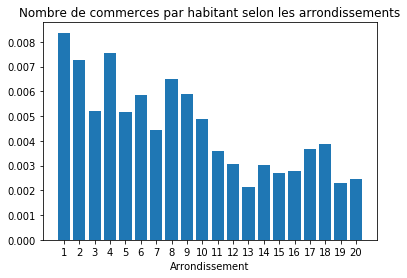

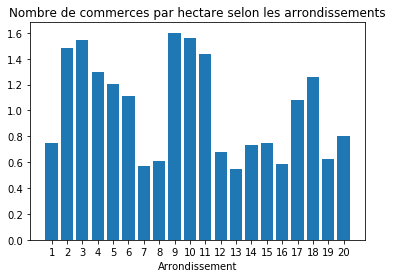

In [38]:
pop_par_ar = [16252,20260,34788,27487,59108,40916,52512,36453,59269,91932,147017,141494,181552,137105,233484,165446,167835,195060,186393,195604]


df_com_arro = df_commerce['ARRO'].value_counts()
X = [str(i) for i in range(1,21)]
Y = [df_com_arro[i+1]/pop_par_ar[i] for i in range(20)]
plt.bar(X,Y)
plt.xlabel('Arrondissement')
plt.title('Nombre de commerces par habitant selon les arrondissements')
plt.show()

"""On remarque que des arrondissements comme le 1er ou le 4ème ont beaucoup de commerces par habitant, au contraire du 13ème qui lui possède  une part de comemrces par habitant plus faible"""

#source INSEE, qu'on peut aussi lire ici https://www.apur.org/sites/default/files/documents/recueil_thematique_1234_arr_paris_0.pdf
#on se donne les surfaces des arrondissements en hectare

surf_arrond =[182,99,117,160,254,215,409,388,218,289,367,639,715,562,850,790,567,600,679,598]
sum(surf_arrond)

Xs = [str(i) for i in range(1,21)]
Ys= [df_com_arro[i+1]/surf_arrond[i] for i in range(20)]

plt.bar(Xs,Ys)
plt.xlabel('Arrondissement')
plt.title('Nombre de commerces par hectare selon les arrondissements')
plt.show()

In [42]:
def calcule_scores_commerces(lat,lon):#fonction qui nous donne un score selon les commerces dans un rayon autour de la position gps (ici le rayon est de 200m)
    lux = ['Commerce détail de boissons', 'Charcuterie - Traiteur - Epicerie fine', 'Chocolaterie - Confiserie', 'Produits alimentaires bio et circuits courts', 'Crèmerie - Fromagerie', 'Torréfacteur - Commerce détail thé et café', 'Poisonnerie', 'Glacier : vente à emporter et consommation sur place', 'Alimentation générale de luxe > 300m²']
    #On crée une liste des boutiques luxueuses, pouvant augmenter le prix du quartier
    distances_aux_commerces = []

    for i,row in df_commerce.iterrows():

        distances_aux_commerces.append((vincenty((row.lat, row.lon), (lat, lon)), row.LIBACT))
    print(len(distances_aux_commerces))
    try:
        score_1 = len([i for i in range(len(distances_aux_commerces)) if distances_aux_commerces[i][0] < 0.5])
    except:
        score_1 = 0

    try:
        score_2 = len([i for i in range(len(distances_aux_commerces)) if distances_aux_commerces[i][0] < 0.5 and distances_aux_commerces[i][1] in lux])
    except:
        score_2 = 0

    return score_1, score_2

In [43]:

def score_commerce(a,b,alpha):
    return alpha*a + (1-alpha)*b

dfml3 = df_ml.copy()
alpha = 0.5

L=[]
for i,row in dfml3.iterrows():
    if  i % 100==0:
        print(i)
    lon = dfml3.loc[i]['lon']
    lat = dfml3.loc[i]['lat']
    a,b = calcule_scores_commerces(lon,lat)
    L.append(score_commerce(a,b,alpha))
dfml3['score_commerce'] = L

"""Créeons une carte de densité des comemrces"""

N=30

maxlon = max(df_commerce['lon'])
minlon = min(df_commerce['lon'])
maxlat = max(df_commerce['lat'])
minlat = min(df_commerce['lat'])

linsplon = list(np.linspace(minlon*(1 -10**-7),maxlon*(1 +10**-7),N))
linsplat = list(np.linspace(minlat*(1 -10**-7),maxlat*(1 +10**-7),N))

def premier_plus_grand(L,x): #renvoie l'indice de la première occurence de la liste triée qui est strmt plus grande que x
    i=0
    while L[i]<= x:
        i+=1
    return i

def donne_zone(lat,lon,Linsplat,Linsplon):
  
    i = premier_plus_grand(Linsplat,lat)
    j = premier_plus_grand(Linsplon,lon)
    return i,j

zones = np.zeros((N,N))
azones = np.zeros((N,N)) #matrice qu'on va afficher pour comprendre

for k in range(len(df_commerce['lat'])):
    i,j = donne_zone(df_commerce['lat'][k],df_commerce['lon'][k], linsplat, linsplon)
    zones[i][j] += 1
    if azones[N-i][j] < 15:
        azones[N-i][j] +=1

plt.imshow(azones, cmap = 'Blues', interpolation = 'bilinear')
plt.colorbar()
plt.show()

def Zone_appart(lat,lon):
    i,j = donne_zone(lat,lon, linsplat, linsplon)
    return zones[i][j]

0
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612
7612


KeyboardInterrupt: 

In [38]:
L1, L2 = [], []

for i, row in df_ml.iterrows():
    (a,b) = calcule_scores_commerces(row.lat, row.lon)
    L1.append(a)
    L2.append(b)

7612
7612
7612


KeyboardInterrupt: 

In [ ]:
df_ml['score_commerce'], df_ml['score_commerce_lux'] = L1, L2 

df_ml['score_commerce'] /= max(df_ml['score_commerce'])
df_ml['score_commerce_lux'] /= max(df_ml['score_commerce_lux'])

In [ ]:
df_ml.sample(10)

In [ ]:
corr_matrix = df_ml.corr()
corr_matrix["prixm2"].sort_values(ascending = False)

In [ ]:
df_ml.to_csv('data/sauvegarde_0.csv')